# package

In [122]:
%pip install dython -q
%pip install --pre pycaret[full] -qq
%pip install toad -qq

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import scipy.stats as stats
from scipy.stats import chi2_contingency
from dython.nominal import associations
from dython.nominal import cramers_v
from pycaret.regression import *

from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# 公式


In [124]:
def get_overview(df):
  missing = []
  unique = []
  types = []
  variables = []
  count = []

  for item in df.columns:
      variables.append(item)
      missing.append(df[item].isnull().sum())
      unique.append(df[item].nunique())
      types.append(df[item].dtypes)
      count.append(len(df[item]))

  output = pd.DataFrame({
      'variable': variables,
      'dtype': types,
      'count': count,
      'unique': unique,
      'missing': missing,

  })
  print("df info : ")
  display(output.sort_values("missing",ascending=False).reset_index(drop=True))

# Read Data

## 資料合體

In [125]:
route = '/content/drive/MyDrive/datasets/nsysu_linear_regression_data'

In [126]:
df_product_info = pd.read_csv(route + '/sephora.csv')
df_reviews_1 = pd.read_csv(route + '/reviews_0-250.csv', index_col = 0, dtype={'author_id':'str'})
df_reviews_2 = pd.read_csv(route + '/reviews_250-500.csv', index_col = 0, dtype={'author_id':'str'})
df_reviews_3 = pd.read_csv(route + '/reviews_500-750.csv', index_col = 0, dtype={'author_id':'str'})
df_reviews_4 = pd.read_csv(route + '/reviews_750-1250.csv', index_col = 0, dtype={'author_id':'str'})
df_reviews_5 = pd.read_csv(route + '/reviews_1250-end.csv', index_col = 0, dtype={'author_id':'str'})

In [127]:
df_reviews = pd.concat([df_reviews_1,df_reviews_2,df_reviews_3,df_reviews_4,df_reviews_5],axis=0)
print("df_reviews shape: ",df_reviews.shape)
print("df_product_info shape: ",df_product_info.shape)

df_reviews shape:  (1094411, 18)
df_product_info shape:  (8494, 27)


In [128]:
cols_to_use = df_product_info.columns.difference(df_reviews.columns)
cols_to_use = list(cols_to_use)
cols_to_use.append('product_id')
print(cols_to_use)

['brand_id', 'child_count', 'child_max_price', 'child_min_price', 'highlights', 'ingredients', 'limited_edition', 'loves_count', 'new', 'online_only', 'out_of_stock', 'primary_category', 'reviews', 'sale_price_usd', 'secondary_category', 'sephora_exclusive', 'size', 'tertiary_category', 'value_price_usd', 'variation_desc', 'variation_type', 'variation_value', 'product_id']


In [129]:
df = pd.merge(df_reviews, df_product_info[cols_to_use], how='outer', on=['product_id', 'product_id'])
df.shape

(1100554, 40)

In [130]:
original_df = df.copy()

## 總覽

In [131]:
get_overview(df)

df info : 


,variable,dtype,count,unique,missing
0,variation_desc,object,1100554,935,1091034
1,sale_price_usd,float64,1100554,88,1090576
2,value_price_usd,float64,1100554,174,1069365
3,child_max_price,float64,1100554,222,644796
4,child_min_price,float64,1100554,208,644796
5,helpfulness,float64,1100554,3767,567735
6,review_title,object,1100554,364105,316797
7,hair_color,object,1100554,7,232911
8,eye_color,object,1100554,6,215771
9,skin_tone,object,1100554,14,176682


###### 範例

In [132]:
df_product_info[df_product_info['product_name'] == 'Water Sleeping Mask with Squalane'].T

,4439
product_id,P479330
product_name,Water Sleeping Mask with Squalane
brand_id,6125
brand_name,LANEIGE
loves_count,78940
rating,4.3623
reviews,472.0
size,2.3 oz/ 70 mL
variation_type,Size
variation_value,2.3 oz/ 70 mL


In [133]:
original_df[
    (original_df['brand_name'] == 'LANEIGE')
    & (original_df['product_name'] == 'Water Sleeping Mask with Squalane')
].head(1).T

,866117
author_id,33602438124
rating,5.0
is_recommended,1.0
helpfulness,NaN
total_feedback_count,0.0
total_neg_feedback_count,0.0
total_pos_feedback_count,0.0
submission_time,2023-03-16
review_text,my skin has been super dry and sensitive ever ...
review_title,my holy grail


##### 推薦評分

In [134]:
df['rating'].value_counts()

,count
rating,
5.0,698951
4.0,199389
3.0,81816
1.0,61223
2.0,53032


In [135]:
df['is_recommended'].value_counts()

,count
is_recommended,
1.0,778160
0.0,148263


<Axes: >

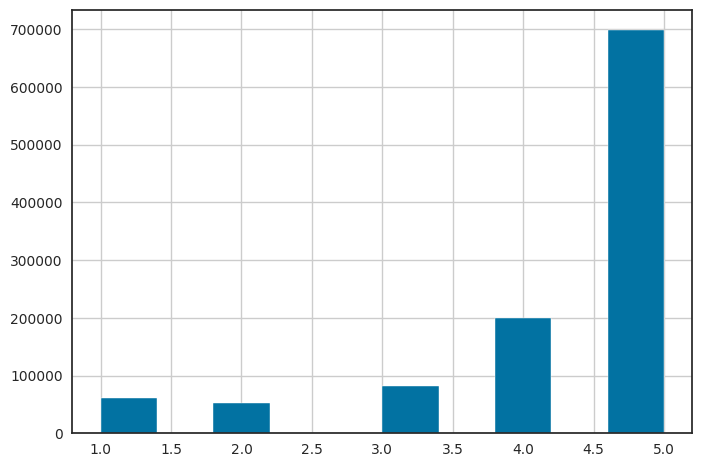

In [136]:
df['rating'].hist()

<Axes: >

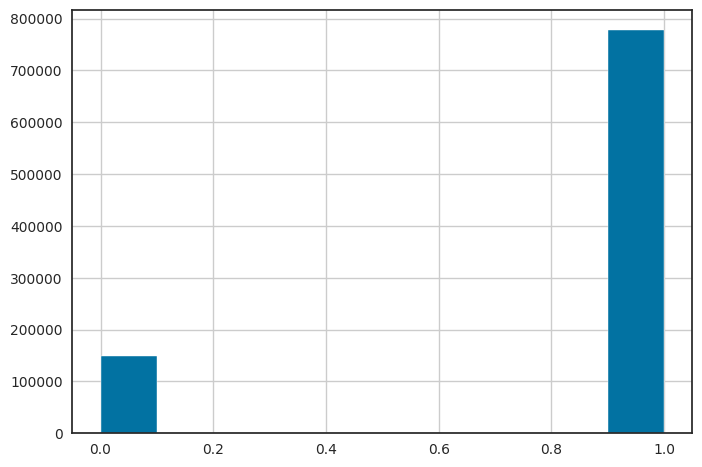

In [137]:
df['is_recommended'].hist()

### 丟棄is_recommended的缺失值

In [138]:
df.dropna(subset=['is_recommended'], axis=0, inplace=True)

## Drop Data

**Too many missing values**

In [139]:
cols = """variation_desc
sale_price_usd
value_price_usd
child_max_price
child_min_price
helpfulness
review_title"""
cols_list = cols.split("\n")
# Drop the columns
df.drop(columns=cols_list,axis=1,inplace=True)

In [140]:
df.head(5)

,author_id,rating,is_recommended,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,submission_time,review_text,skin_tone,eye_color,...,online_only,out_of_stock,primary_category,reviews,secondary_category,sephora_exclusive,size,tertiary_category,variation_type,variation_value
0,1741593524,5.0,1.0,2.0,0.0,2.0,2023-02-01,I use this with the Nudestix “Citrus Clean Bal...,NaN,brown,...,1,0,Skincare,1.0,Cleansers,0,2.4 oz / 70 ml,NaN,Size,2.4 oz / 70 ml
1,31423088263,1.0,0.0,0.0,0.0,0.0,2023-03-21,I bought this lip mask after reading the revie...,NaN,NaN,...,0,0,Skincare,16118.0,Lip Balms & Treatments,1,0.7 oz/ 20 g,NaN,Color,Original
2,5061282401,5.0,1.0,0.0,0.0,0.0,2023-03-21,My review title says it all! I get so excited ...,light,brown,...,0,0,Skincare,16118.0,Lip Balms & Treatments,1,0.7 oz/ 20 g,NaN,Color,Original
3,6083038851,5.0,1.0,0.0,0.0,0.0,2023-03-20,I’ve always loved this formula for a long time...,NaN,brown,...,0,0,Skincare,16118.0,Lip Balms & Treatments,1,0.7 oz/ 20 g,NaN,Color,Original
4,47056667835,5.0,1.0,0.0,0.0,0.0,2023-03-20,"If you have dry cracked lips, this is a must h...",light,hazel,...,0,0,Skincare,16118.0,Lip Balms & Treatments,1,0.7 oz/ 20 g,NaN,Color,Original


**useless**

author_id, review_text

In [141]:
cols = """author_id
review_text"""
cols_list = cols.split("\n")
# Drop the columns
df.drop(columns=cols_list,axis=1,inplace=True)

In [142]:
get_overview(df)

df info : 


,variable,dtype,count,unique,missing
0,tertiary_category,object,926423,30,135152
1,highlights,object,926423,1622,80983
2,hair_color,object,926423,7,58780
3,variation_value,object,926423,527,54907
4,variation_type,object,926423,6,44632
5,eye_color,object,926423,6,42312
6,size,object,926423,517,40763
7,skin_tone,object,926423,14,40480
8,skin_type,object,926423,4,19068
9,ingredients,object,926423,2051,14631


### 看時間對推薦的差別

In [143]:
submission_time = pd.to_datetime(df['submission_time'])

df_for_time = df[['is_recommended']].copy()
df_for_time['year'] = submission_time.dt.year
df_for_time['month'] = submission_time.dt.month
df_for_time['day'] = submission_time.dt.day

In [144]:
df_for_time.head(5)

,is_recommended,year,month,day
0,1.0,2023,2,1
1,0.0,2023,3,21
2,1.0,2023,3,21
3,1.0,2023,3,20
4,1.0,2023,3,20


In [145]:
is_recommended_0 = df_for_time[df_for_time['is_recommended'] == 0]
is_recommended_1 = df_for_time[df_for_time['is_recommended'] == 1]


<Axes: xlabel='year', ylabel='is_recommended'>

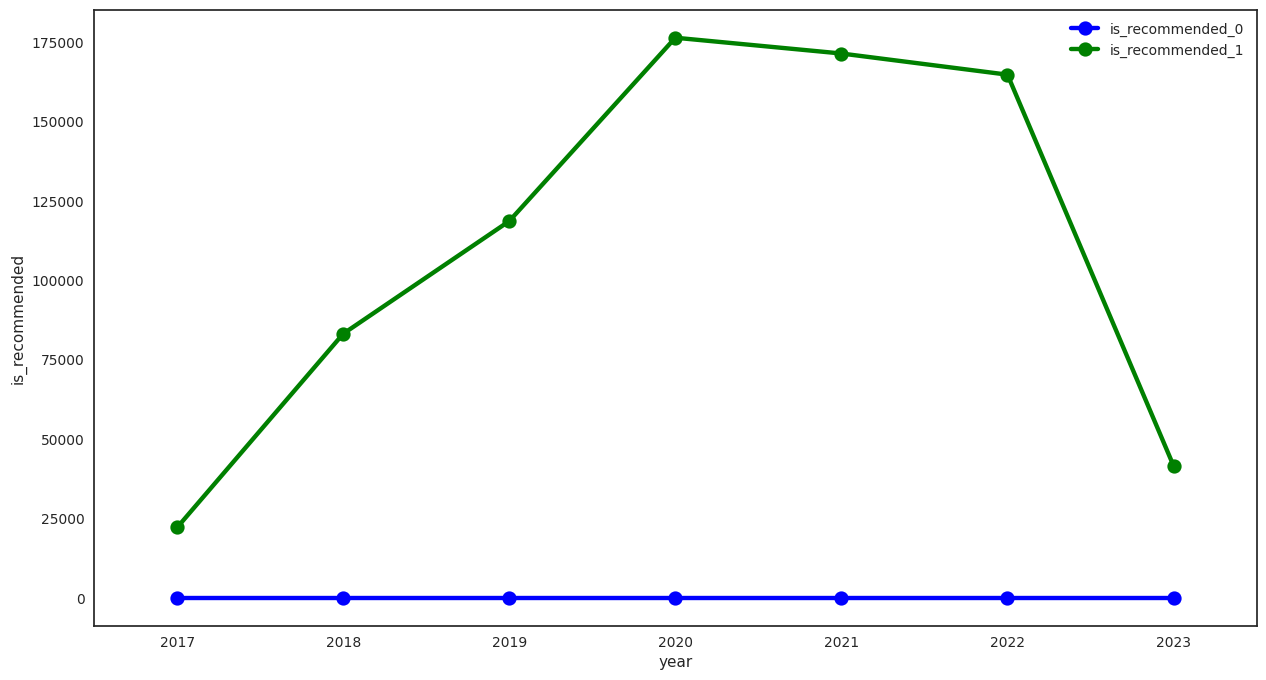

In [146]:
fig, (ax1) = plt.subplots(1, 1, figsize= (15,8))

is_recommended_0 = is_recommended_0.groupby('year').sum(numeric_only=True)['is_recommended'].reset_index()
sns.pointplot(is_recommended_0,x='year',y='is_recommended', color="blue", label="is_recommended_0",ax=ax1)

is_recommended_1 = is_recommended_1.groupby('year').sum(numeric_only=True)['is_recommended'].reset_index()
sns.pointplot(is_recommended_1,x='year',y='is_recommended', color="green", label="is_recommended_1",ax=ax1)


In [147]:
df_for_time.groupby('year')['is_recommended'].value_counts()

year  is_recommended
2017  1.0                22129
      0.0                 3261
2018  1.0                83157
      0.0                14839
2019  1.0               118662
      0.0                25198
2020  1.0               176422
      0.0                39027
2021  1.0               171447
      0.0                30565
2022  1.0               164784
      0.0                27443
2023  1.0                41559
      0.0                 7930
Name: count, dtype: int64

In [148]:
df.drop(columns=['submission_time'],axis=1,inplace=True)

In [149]:
get_overview(df)

df info : 


,variable,dtype,count,unique,missing
0,tertiary_category,object,926423,30,135152
1,highlights,object,926423,1622,80983
2,hair_color,object,926423,7,58780
3,variation_value,object,926423,527,54907
4,variation_type,object,926423,6,44632
5,eye_color,object,926423,6,42312
6,size,object,926423,517,40763
7,skin_tone,object,926423,14,40480
8,skin_type,object,926423,4,19068
9,ingredients,object,926423,2051,14631


## 分群 對 category

In [150]:
df['primary_category'].value_counts()

,count
primary_category,
Skincare,926423


In [151]:
df.drop(df[df['primary_category'] != 'Skincare'].index, inplace = True)
df['primary_category'].value_counts()

,count
primary_category,
Skincare,926423


In [152]:
df.drop(columns=['primary_category'],axis=1,inplace=True)

剩下926423筆資料

### Primary不能用 看 Secondary

In [153]:
get_overview(df)

df info : 


,variable,dtype,count,unique,missing
0,tertiary_category,object,926423,30,135152
1,highlights,object,926423,1622,80983
2,hair_color,object,926423,7,58780
3,variation_value,object,926423,527,54907
4,variation_type,object,926423,6,44632
5,eye_color,object,926423,6,42312
6,size,object,926423,517,40763
7,skin_tone,object,926423,14,40480
8,skin_type,object,926423,4,19068
9,ingredients,object,926423,2051,14631


In [154]:
df.groupby(['secondary_category', 'tertiary_category'])['is_recommended'].value_counts()

secondary_category  tertiary_category      is_recommended
Cleansers           Blotting Papers        1.0                  84
                                           0.0                  20
                    Exfoliators            1.0               18101
                                           0.0                1974
                    Face Wash & Cleansers  1.0               77756
                                                             ...  
Wellness            Beauty Supplements     0.0                1115
                    Facial Rollers         1.0                1338
                                           0.0                 374
                    Holistic Wellness      1.0                 696
                                           0.0                 275
Name: count, Length: 62, dtype: int64

In [155]:
# Calculate counts for recommended (is_recommended == 1) and not recommended (is_recommended == 0)
recommended_1 = df[df['is_recommended'] == 1].groupby(['secondary_category', 'tertiary_category'])['is_recommended'].count()
recommended_0 = df[df['is_recommended'] == 0].groupby(['secondary_category', 'tertiary_category'])['is_recommended'].count()

# Convert the counts to DataFrames for alignment
recommended_1 = recommended_1.reset_index(name='count_1')
recommended_0 = recommended_0.reset_index(name='count_0')

# Merge the two DataFrames on 'secondary_category' and 'tertiary_category'
recommended = pd.merge(recommended_1, recommended_0, on=['secondary_category', 'tertiary_category'], how='outer').fillna(0)

# Calculate the recommended ratio
recommended['recommended_ratio'] = recommended['count_1'] / (recommended['count_1'] + recommended['count_0'])

# Display the result
recommended

,secondary_category,tertiary_category,count_1,count_0,recommended_ratio
0,Cleansers,Blotting Papers,84,20,0.807692
1,Cleansers,Exfoliators,18101,1974,0.901669
2,Cleansers,Face Wash & Cleansers,77756,16100,0.828461
3,Cleansers,Face Wipes,2926,839,0.777158
4,Cleansers,Makeup Removers,8592,1112,0.885408
5,Cleansers,Toners,25363,4469,0.850194
6,Eye Care,Eye Creams & Treatments,51506,10615,0.829124
7,Eye Care,Eye Masks,3183,879,0.783604
8,High Tech Tools,Anti-Aging,2387,527,0.819149
9,High Tech Tools,Facial Cleansing Brushes,937,281,0.769294


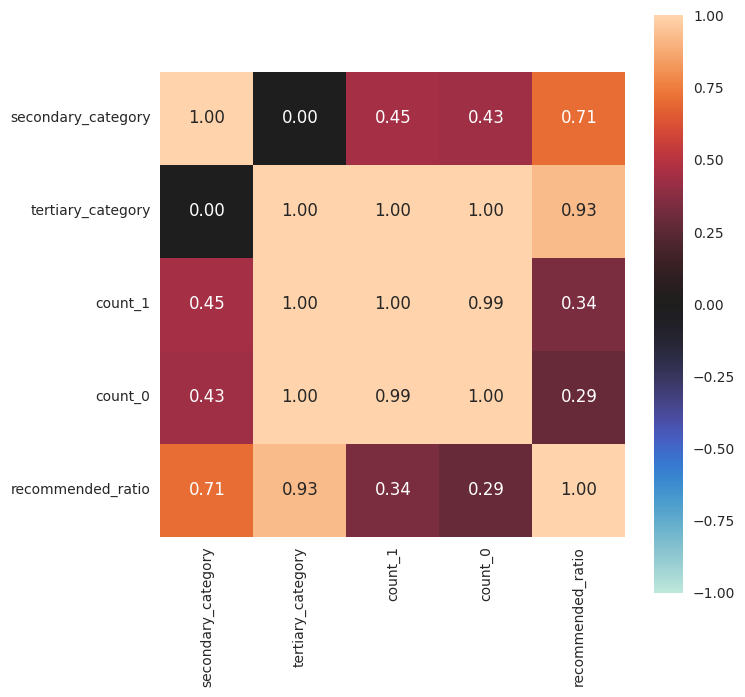

{'corr':                     secondary_category  tertiary_category   count_1   count_0  \
 secondary_category            1.000000           0.000000  0.452750  0.432761   
 tertiary_category             0.000000           1.000000  0.999967  0.999951   
 count_1                       0.452750           0.999967  1.000000  0.993529   
 count_0                       0.432761           0.999951  0.993529  1.000000   
 recommended_ratio             0.707224           0.928936  0.337310  0.288405   
 
                     recommended_ratio  
 secondary_category           0.707224  
 tertiary_category            0.928936  
 count_1                      0.337310  
 count_0                      0.288405  
 recommended_ratio            1.000000  ,
 'ax': <Axes: >}

In [156]:
associations(recommended)

#### 刪掉tertiary category 的缺失值

In [157]:
df.groupby(['secondary_category', 'tertiary_category'])['product_id'].value_counts()

secondary_category  tertiary_category  product_id
Cleansers           Blotting Papers    P460746         54
                                       P428422         33
                                       P482314         15
                                       P505332          2
                    Exfoliators        P423688       4600
                                                     ... 
Wellness            Holistic Wellness  P476860         19
                                       P464288         17
                                       P472068         13
                                       P477761          8
                                       P474090          2
Name: count, Length: 1999, dtype: int64

In [158]:
miss_ter = df[df['tertiary_category'].isnull()]['secondary_category'].value_counts()

In [159]:
all_sec = df['secondary_category'].value_counts()

In [160]:
miss_ter = miss_ter/all_sec
miss_ter

,count
secondary_category,
Cleansers,0.000762
Eye Care,NaN
High Tech Tools,0.006618
Lip Balms & Treatments,1.000000
Masks,NaN
Mini Size,1.000000
Moisturizers,0.000049
Self Tanners,0.090768
Shop by Concern,NaN


In [161]:
del_idx = df[df['secondary_category'].isin(miss_ter[miss_ter == 1].index)].index

df.drop(del_idx, inplace=True)

df['tertiary_category'].isnull().sum()

1971

In [162]:
df.drop(df[df['tertiary_category'].isnull()].index, inplace=True)

get_overview(df)

df info : 


,variable,dtype,count,unique,missing
0,highlights,object,791271,1419,76175
1,hair_color,object,791271,7,50127
2,variation_value,object,791271,467,44269
3,eye_color,object,791271,6,35689
4,skin_tone,object,791271,14,34495
5,variation_type,object,791271,6,34466
6,size,object,791271,457,24603
7,skin_type,object,791271,4,15693
8,ingredients,object,791271,1798,12802
9,tertiary_category,object,791271,30,0


##### 刪掉Shop by Concern 讓 Sec 和 Ter one-to-one

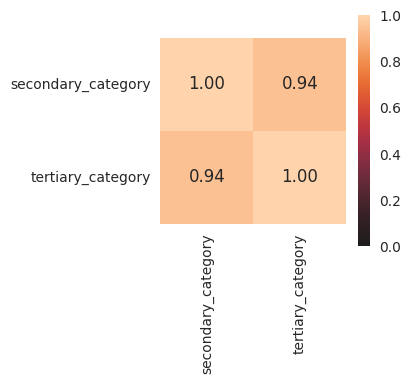

{'corr':                     secondary_category  tertiary_category
 secondary_category            1.000000           0.942938
 tertiary_category             0.942938           1.000000,
 'ax': <Axes: >}

In [163]:
associations(df[['secondary_category','tertiary_category']])

In [164]:
cramers_v(df['secondary_category'],df['tertiary_category'])

0.9429384005526188

In [165]:
df.groupby(['secondary_category'])['tertiary_category'].value_counts()

secondary_category  tertiary_category        
Cleansers           Face Wash & Cleansers         93856
                    Toners                        29832
                    Exfoliators                   20075
                    Makeup Removers                9704
                    Face Wipes                     3765
                    Blotting Papers                 104
Eye Care            Eye Creams & Treatments       62121
                    Eye Masks                      4062
High Tech Tools     Anti-Aging                     2914
                    Facial Cleansing Brushes       1218
                    Teeth Whitening                 841
                    Hair Removal                    581
Masks               Face Masks                    53798
                    Sheet Masks                    2959
Moisturizers        Moisturizers                 180958
                    Face Oils                     26307
                    Mists & Essences              24826
                    BB & CC Creams                 7328
                    Night Creams                   6213
                    Decollete & Neck Creams         902
Self Tanners        For Face                       5713
                    For Body                       4835
Shop by Concern     Anti-Aging                       15
Sunscreen           Face Sunscreen                37246
                    Body Sunscreen                  852
Treatments          Face Serums                  163807
                    Facial Peels                  23175
                    Blemish & Acne Treatments     13948
Wellness            Beauty Supplements             6633
                    Facial Rollers                 1712
                    Holistic Wellness               971
Name: count, dtype: int64

In [166]:
del_row = df[df['secondary_category'] == 'Shop by Concern']
df.drop(del_row.index, inplace=True)

###### 查他是什麼

In [167]:
original_df.loc[del_row.index][['product_id','brand_name','product_name','size']]

,product_id,brand_name,product_name,size
1091792,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091793,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091794,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091795,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091796,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091797,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091798,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091799,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091800,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL
1091801,P429538,fresh,Lotus Youth Preseve Rescue Mask Mini,1 oz/ 30 mL


URL : https://www.fresh.com/us/skincare/collections/lotus/lotus-youth-preserve-exfoliating-rescue-mask-H00007011.html

Image :

#### 解決category的缺失值

In [168]:
df.drop('secondary_category', axis=1, inplace=True)

In [169]:
get_overview(df)

df info : 


,variable,dtype,count,unique,missing
0,highlights,object,791256,1419,76160
1,hair_color,object,791256,7,50127
2,variation_value,object,791256,467,44269
3,eye_color,object,791256,6,35689
4,skin_tone,object,791256,14,34495
5,variation_type,object,791256,6,34466
6,size,object,791256,457,24603
7,skin_type,object,791256,4,15693
8,ingredients,object,791256,1798,12802
9,tertiary_category,object,791256,30,0


## 解決其他變數

In [170]:
get_overview(df)

df info : 


,variable,dtype,count,unique,missing
0,highlights,object,791256,1419,76160
1,hair_color,object,791256,7,50127
2,variation_value,object,791256,467,44269
3,eye_color,object,791256,6,35689
4,skin_tone,object,791256,14,34495
5,variation_type,object,791256,6,34466
6,size,object,791256,457,24603
7,skin_type,object,791256,4,15693
8,ingredients,object,791256,1798,12802
9,tertiary_category,object,791256,30,0


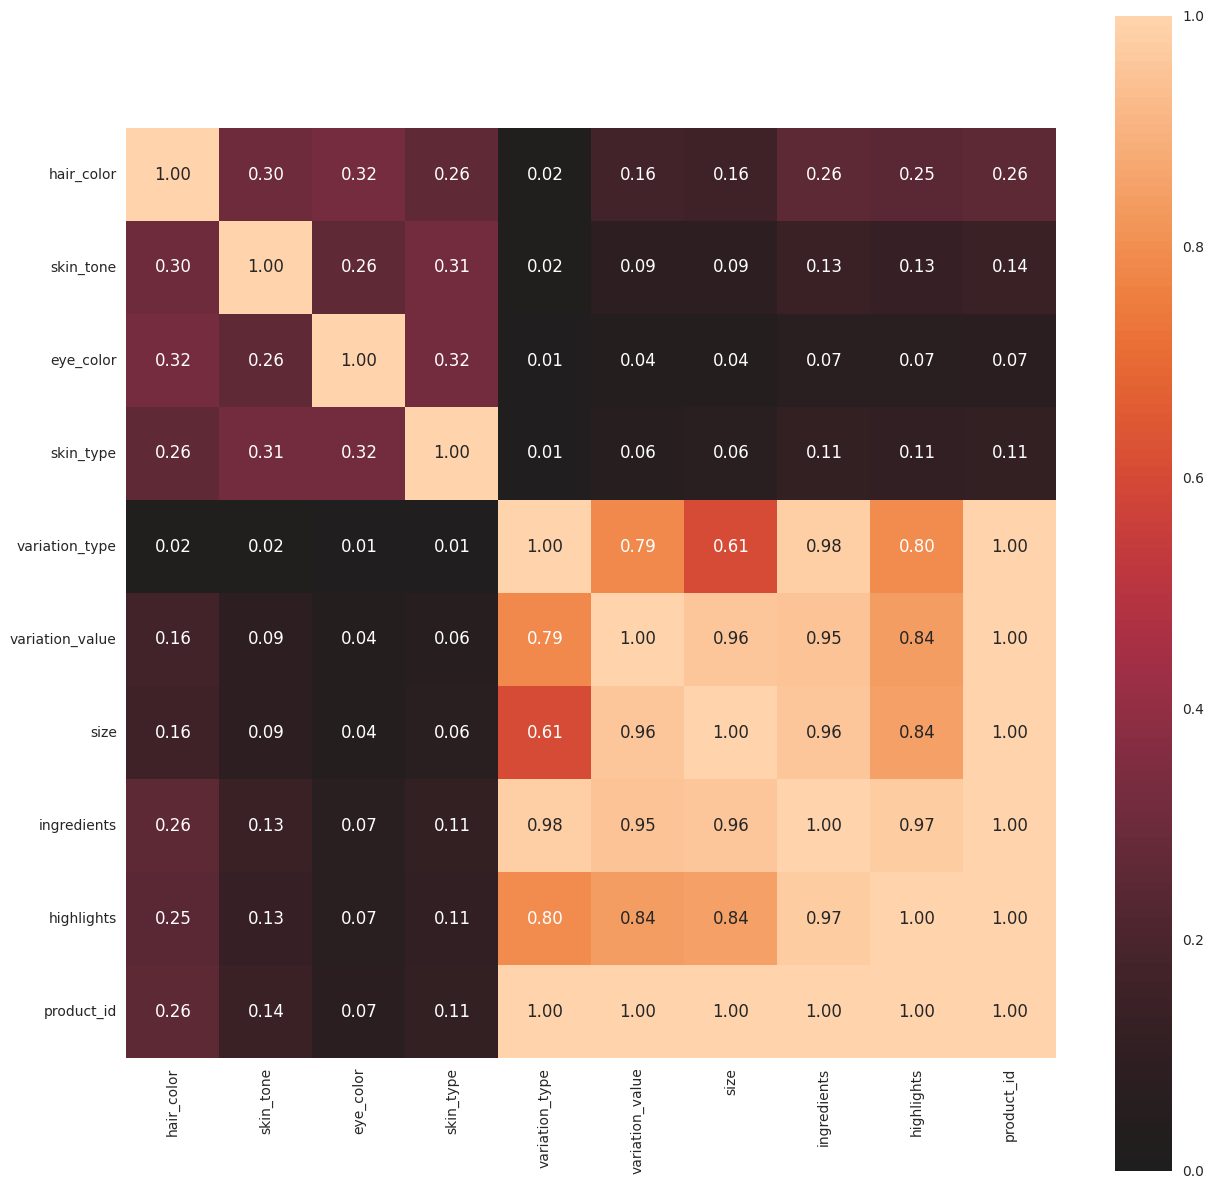

{'corr':                  hair_color  skin_tone  eye_color  skin_type  variation_type  \
 hair_color         1.000000   0.298439   0.321023   0.261318        0.017041   
 skin_tone          0.298439   1.000000   0.260573   0.312834        0.017383   
 eye_color          0.321023   0.260573   1.000000   0.317074        0.009297   
 skin_type          0.261318   0.312834   0.317074   1.000000        0.009424   
 variation_type     0.017041   0.017383   0.009297   0.009424        1.000000   
 variation_value    0.164227   0.086985   0.042273   0.061898        0.787624   
 size               0.162197   0.086122   0.041854   0.062503        0.606573   
 ingredients        0.255933   0.134341   0.070287   0.113053        0.982162   
 highlights         0.247879   0.130486   0.067830   0.107326        0.796748   
 product_id         0.257307   0.135208   0.072510   0.114286        0.998741   
 
                  variation_value      size  ingredients  highlights  \
 hair_color              0.

In [171]:
need_check = ['hair_color', 'skin_tone', 'eye_color', 'skin_type', 'variation_type', 'variation_value', 'size', 'ingredients', 'highlights']

associations(df[[*need_check, 'product_id']])

#### Personal Status

In [172]:
personal_status = ['hair_color','eye_color','skin_tone','skin_type']

In [173]:
pain_df = df.groupby(personal_status)['tertiary_category'].value_counts()

pain_df

hair_color  eye_color  skin_tone  skin_type    tertiary_category    
auburn      Grey       deep       normal       Face Masks                1
                                               Moisturizers              1
                       fair       combination  Moisturizers             21
                                               Face Wash & Cleansers     8
                                               Face Serums               8
                                                                        ..
red         hazel      tan        combination  Moisturizers              1
                                               Face Sunscreen            1
                                  oily         Face Serums               3
                                               Exfoliators               1
                                               Moisturizers              1
Name: count, Length: 15389, dtype: int64

In [174]:
pain_df = pain_df.reset_index(name='count')
pain_df = pain_df.sort_values('count', ascending=False)
pain_df

,hair_color,eye_color,skin_tone,skin_type,tertiary_category,count
9426,brown,brown,lightMedium,combination,Moisturizers,7215
9427,brown,brown,lightMedium,combination,Face Serums,6539
9307,brown,brown,light,combination,Moisturizers,6195
9308,brown,brown,light,combination,Face Serums,5526
3177,black,brown,lightMedium,combination,Moisturizers,4446
...,...,...,...,...,...,...
7965,blonde,hazel,mediumTan,combination,For Body,1
7964,blonde,hazel,mediumTan,combination,Night Creams,1
7963,blonde,hazel,mediumTan,combination,Teeth Whitening,1
7962,blonde,hazel,mediumTan,combination,Anti-Aging,1


## Personal Status drop

In [175]:
df.drop(columns=['hair_color','eye_color','skin_tone','skin_type'],axis=1,inplace=True)

## Overview 合成資料

In [176]:
get_overview(df)

df info : 


,variable,dtype,count,unique,missing
0,highlights,object,791256,1419,76160
1,variation_value,object,791256,467,44269
2,variation_type,object,791256,6,34466
3,size,object,791256,457,24603
4,ingredients,object,791256,1798,12802
5,product_id,object,791256,1998,0
6,new,int64,791256,2,0
7,total_feedback_count,float64,791256,618,0
8,tertiary_category,object,791256,30,0
9,total_neg_feedback_count,float64,791256,240,0


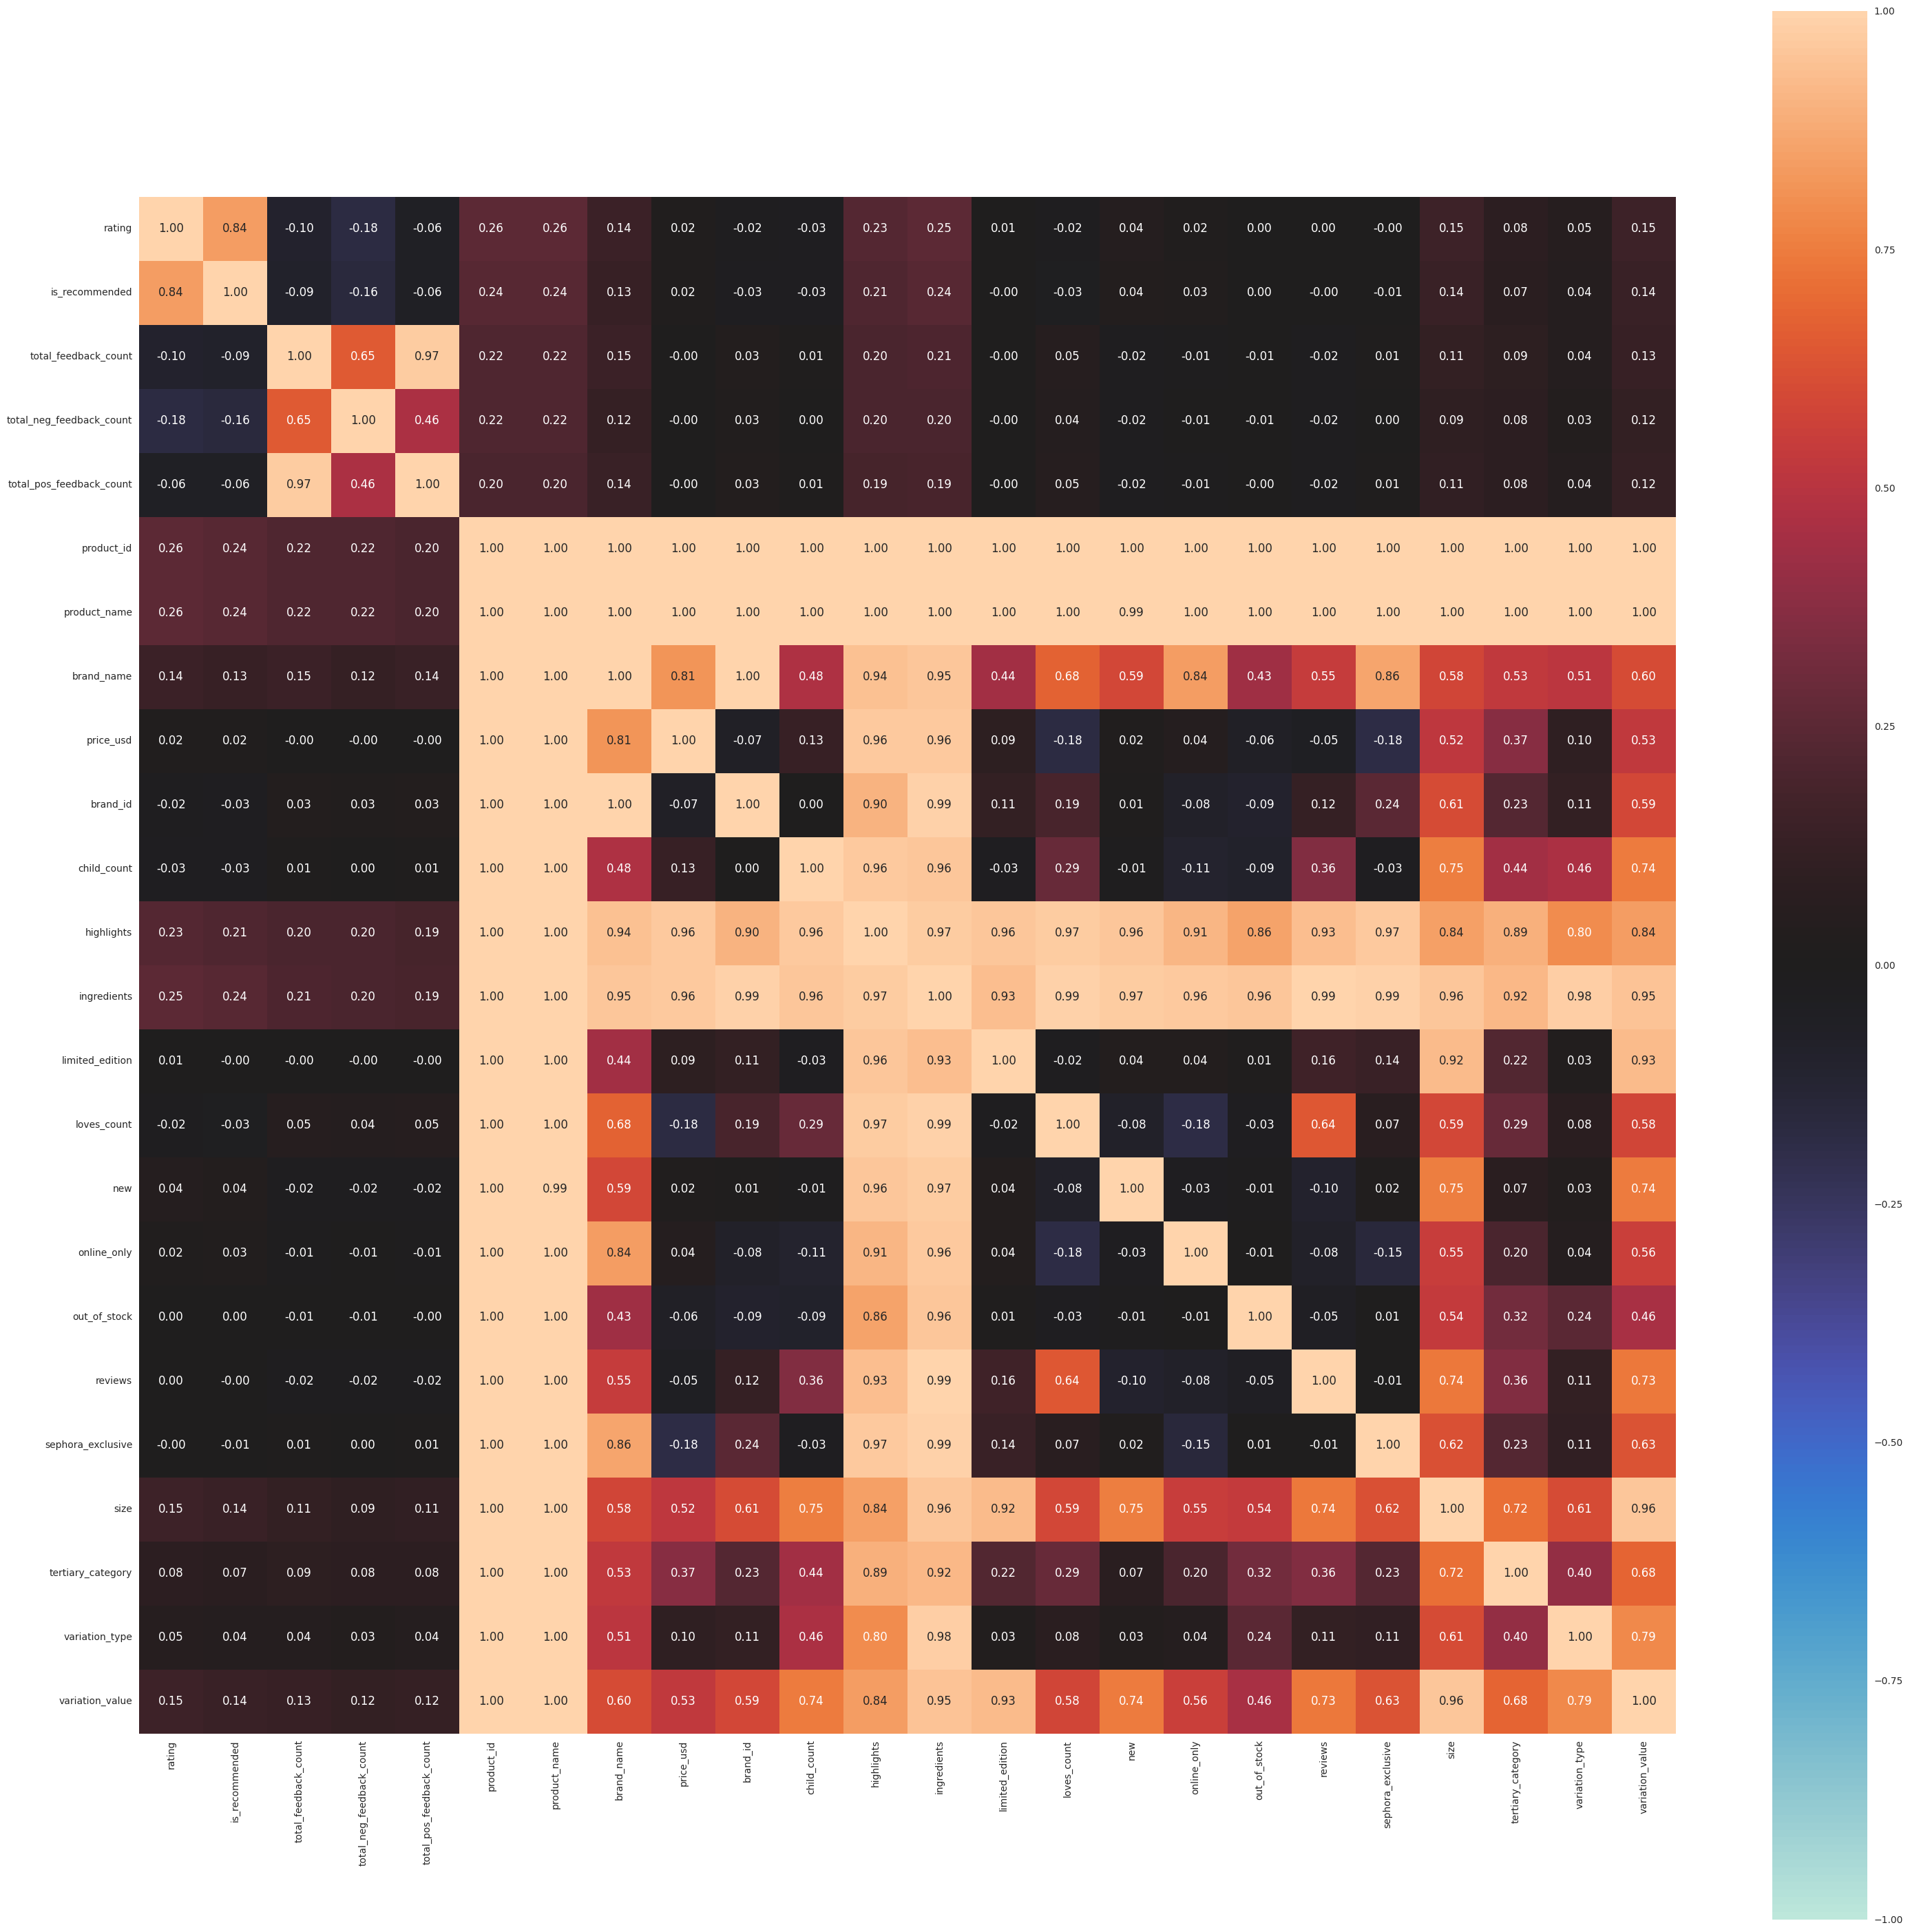

{'corr':                             rating  is_recommended  total_feedback_count  \
 rating                    1.000000        0.843544             -0.098875   
 is_recommended            0.843544        1.000000             -0.092734   
 total_feedback_count     -0.098875       -0.092734              1.000000   
 total_neg_feedback_count -0.179513       -0.160627              0.650552   
 total_pos_feedback_count -0.062265       -0.060686              0.974426   
 product_id                0.256693        0.240130              0.218734   
 product_name              0.256316        0.239873              0.218585   
 brand_name                0.141000        0.131633              0.148287   
 price_usd                 0.020130        0.018333             -0.002152   
 brand_id                 -0.015683       -0.028606              0.034075   
 child_count              -0.028605       -0.028073              0.008002   
 highlights                0.229705        0.214701              0.2

In [177]:
associations(df)

In [178]:
dict_id = {}
for row in df['product_id'].value_counts().index:
  row_df = df[df['product_id'] == row]
  dict_id[row] = row_df

In [179]:
need_adjust = ['rating','is_recommended','total_feedback_count','total_neg_feedback_count','total_pos_feedback_count']

In [180]:
final_df = pd.DataFrame()

final_df['product_id'] = df['product_id'].unique()

final_df

,product_id
0,P7880
1,P218700
2,P248407
3,P269122
4,P394639
...,...
1993,P480441
1994,P469829
1995,P505174
1996,P476571


In [181]:
for key in dict_id.keys():
  for idx in dict_id[key].nunique().index:
    # Check if the column exists in final_df, if not, create it
    if idx not in final_df.columns:
      final_df[idx] = pd.Series(dtype=dict_id[key][idx].dtype) # Create column with appropriate data type

    if dict_id[key][idx].nunique() > 1:
      final_df.loc[final_df['product_id']==key, idx] = dict_id[key][idx].mean()
    else:
      final_df.loc[final_df['product_id']==key, idx] = dict_id[key][idx].values[0]

final_df

,product_id,rating,is_recommended,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,product_name,brand_name,price_usd,brand_id,...,loves_count,new,online_only,out_of_stock,reviews,sephora_exclusive,size,tertiary_category,variation_type,variation_value
0,P7880,4.286325,0.832764,1.513675,0.470940,1.042735,Soy Hydrating Gentle Face Cleanser,fresh,39.0,4348.0,...,282865.0,0.0,0.0,0.0,8733.0,0.0,5 oz/ 150 mL,Face Wash & Cleansers,Size,5 oz/ 150 mL
1,P218700,4.358300,0.859312,3.348178,0.677126,2.671053,100 percent Pure Argan Oil,Josie Maran,49.0,5922.0,...,134089.0,0.0,0.0,0.0,7763.0,0.0,1.7 oz/ 50 mL,Face Oils,Size,1.7 oz/ 50 mL
2,P248407,4.342334,0.834325,4.047597,0.866819,3.180778,Ultra Repair Cream Intense Hydration,First Aid Beauty,38.0,5972.0,...,300432.0,0.0,0.0,0.0,7539.0,0.0,6 oz/ 170 g,Moisturizers,Size,6 oz/ 170 g
3,P269122,4.548879,0.940250,2.583975,0.597500,1.986475,Alpha Beta Extra Strength Daily Peel Pads,Dr. Dennis Gross Skincare,92.0,5668.0,...,234295.0,0.0,0.0,0.0,7412.0,1.0,30 Treatments + 5 Bonus,Facial Peels,Size,30 Treatments + 5 Bonus
4,P394639,4.486359,0.897692,1.167016,0.277894,0.889122,The True Cream Aqua Bomb,belif,38.0,7075.0,...,265050.0,0.0,0.0,0.0,7292.0,0.0,1.68 oz/ 50 mL,Moisturizers,Size,1.68 oz/ 50 mL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1993,P480441,3.000000,0.000000,6.000000,0.000000,6.000000,Retinol + Bakuchiol Serum 2.5x,Dr. Lara Devgan Scientific Beauty,300.0,6318.0,...,581.0,0.0,1.0,0.0,1.0,0.0,1 oz/ 30 mL,Face Serums,Size,1 oz/ 30 mL
1994,P469829,5.000000,1.000000,20.000000,3.000000,17.000000,Equilibrium Biomimetic Skin Active Serum,Hourglass,198.0,5879.0,...,482.0,0.0,0.0,0.0,1.0,0.0,1.7 oz/ 50 mL,Face Serums,Size,1.7 oz/ 50 mL
1995,P505174,5.000000,1.000000,3.000000,0.000000,3.000000,Soft Clean Moisture Rich Foaming Cleanser,Estée Lauder,26.0,6089.0,...,435.0,1.0,0.0,0.0,1.0,0.0,4.5 oz / 125 mL,Face Wash & Cleansers,Size,4.5 oz / 125 mL
1996,P476571,5.000000,1.000000,1.000000,0.000000,1.000000,Turbo Body Lotion Energizing Gel Moisturizer w...,Jack Black,38.0,3297.0,...,326.0,0.0,1.0,0.0,1.0,0.0,16 oz/ 473 mL,Moisturizers,Size,16 oz/ 473 mL


In [182]:
get_overview(final_df)

df info : 


,variable,dtype,count,unique,missing
0,highlights,object,1998,1419,369
1,variation_value,object,1998,467,208
2,variation_type,object,1998,6,170
3,size,object,1998,457,155
4,ingredients,object,1998,1798,116
5,total_pos_feedback_count,float64,1998,1829,0
6,new,float64,1998,2,0
7,is_recommended,float64,1998,1375,0
8,tertiary_category,object,1998,30,0
9,total_feedback_count,float64,1998,1862,0


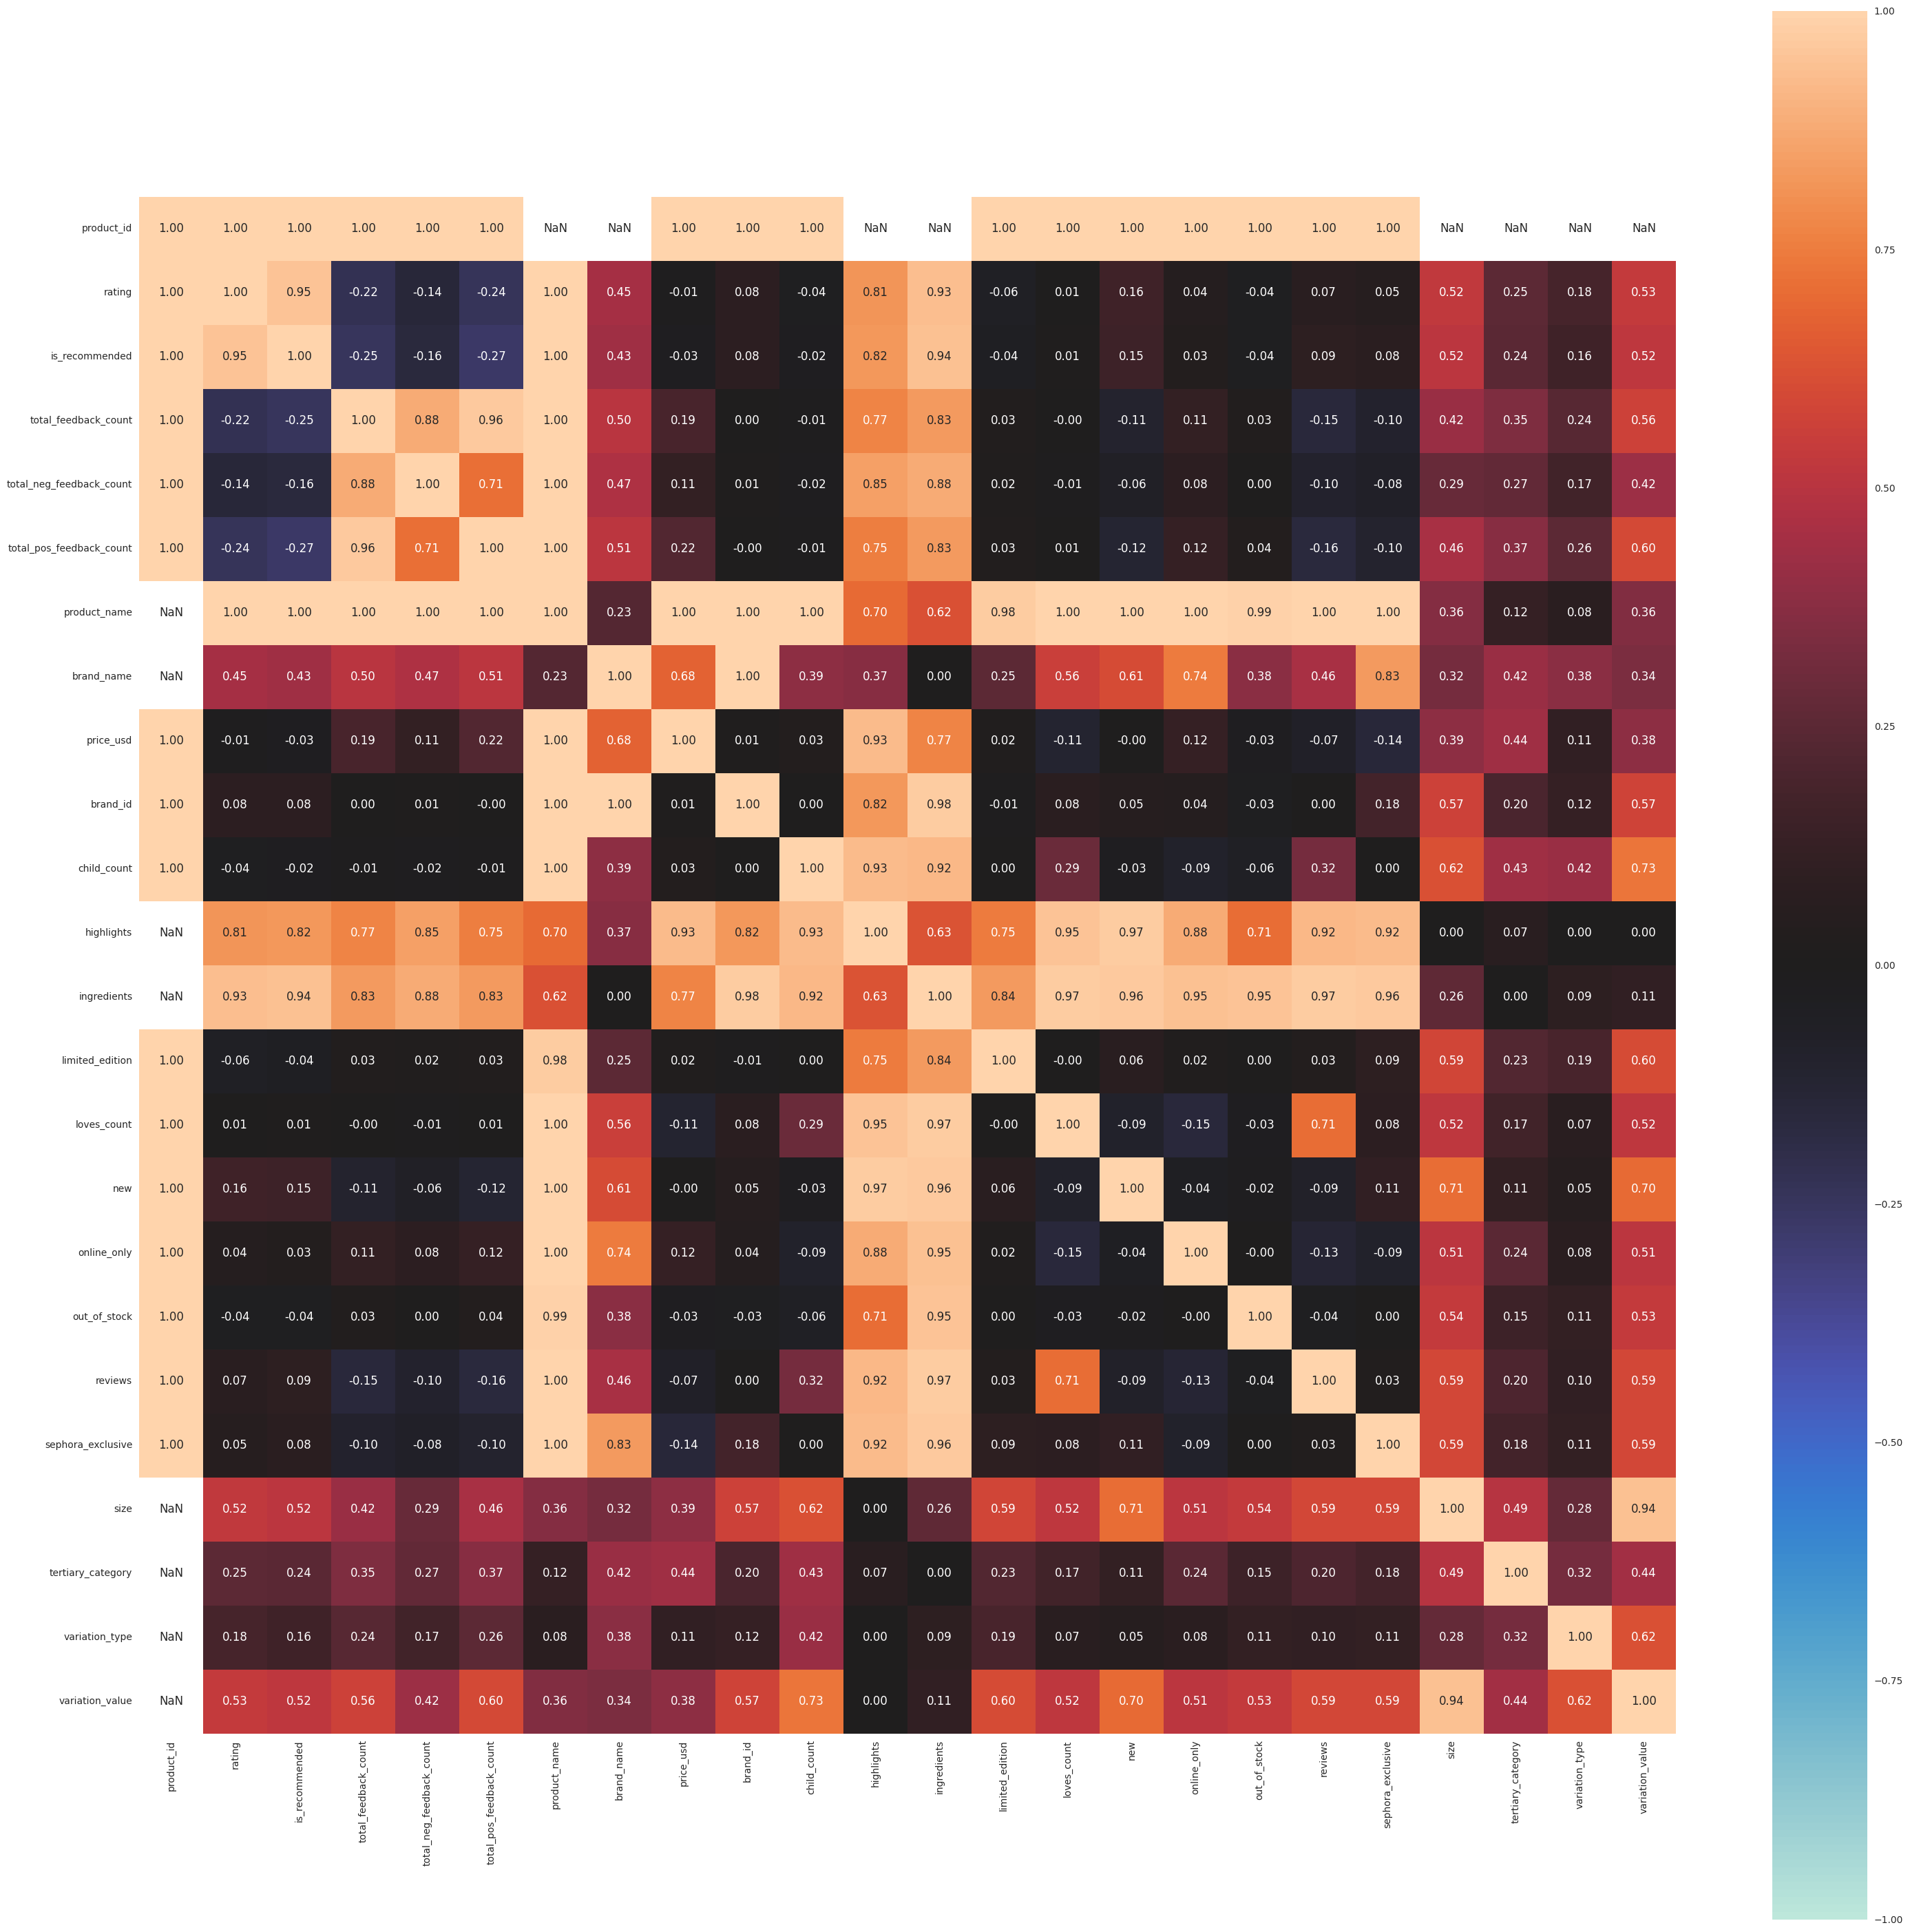

{'corr':                           product_id    rating  is_recommended  \
 product_id                       1.0  1.000000        1.000000   
 rating                           1.0  1.000000        0.946825   
 is_recommended                   1.0  0.946825        1.000000   
 total_feedback_count             1.0 -0.221745       -0.249333   
 total_neg_feedback_count         1.0 -0.143984       -0.159827   
 total_pos_feedback_count         1.0 -0.241465       -0.272659   
 product_name                     0.0  0.998914        0.998793   
 brand_name                       0.0  0.447699        0.431331   
 price_usd                        1.0 -0.008886       -0.027748   
 brand_id                         1.0  0.083717        0.083135   
 child_count                      1.0 -0.037117       -0.023797   
 highlights                       0.0  0.813595        0.824966   
 ingredients                      0.0  0.931294        0.943445   
 limited_edition                  1.0 -0.055811       

In [183]:
associations(final_df)

## Final df EDA

評分對類別平均

In [184]:
final_df.groupby('tertiary_category')['is_recommended'].mean().sort_values(ascending=False)

,is_recommended
tertiary_category,
Facial Peels,0.894851
Exfoliators,0.881476
Makeup Removers,0.878864
Facial Cleansing Brushes,0.863771
Teeth Whitening,0.860325
Face Oils,0.857116
Face Serums,0.839380
Toners,0.839316
Face Masks,0.830321


In [185]:
final_df[(final_df['is_recommended']==1.0) & (final_df['rating']==5.0)].sort_values('total_feedback_count', ascending=False).head(1).T

,1972
product_id,P423167
rating,5.0
is_recommended,1.0
total_feedback_count,87.5
total_neg_feedback_count,12.5
total_pos_feedback_count,75.0
product_name,Future Solution LX Total Protective Cream Broa...
brand_name,Shiseido
price_usd,270.0
brand_id,5337.0


In [186]:
print(final_df[(final_df['is_recommended']==1.0) & (final_df['rating']==5.0)].sort_values('total_feedback_count', ascending=False)['product_name'].head(1))

1972    Future Solution LX Total Protective Cream Broa...
Name: product_name, dtype: object


In [187]:
final_df[final_df['is_recommended'] == 0].sort_values('rating', ascending=True).head(1).T

,1973
product_id,P500464
rating,1.0
is_recommended,0.0
total_feedback_count,7.0
total_neg_feedback_count,2.5
total_pos_feedback_count,4.5
product_name,NuBODY - Body Toning Device
brand_name,NuFACE
price_usd,399.0
brand_id,6001.0


In [188]:
final_df[['rating','is_recommended']].corr()

,rating,is_recommended
rating,1.000000,0.946825
is_recommended,0.946825,1.000000


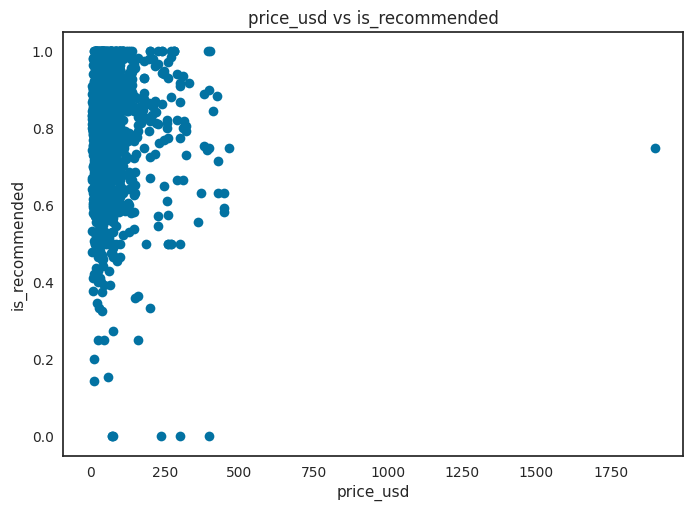

In [189]:
plt.plot(final_df['price_usd'],final_df['is_recommended'], 'o')
plt.xlabel('price_usd')
plt.ylabel('is_recommended')
plt.title('price_usd vs is_recommended')
plt.show()

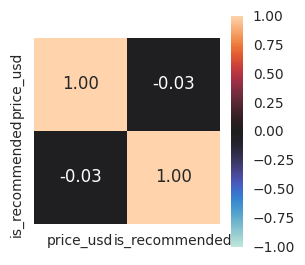

{'corr':                 price_usd  is_recommended
 price_usd        1.000000       -0.027748
 is_recommended  -0.027748        1.000000,
 'ax': <Axes: >}

In [190]:
associations(final_df[['price_usd','is_recommended']], num_num_assoc='pearson')

In [191]:
final_df.groupby('brand_name')['is_recommended'].mean().sort_values(ascending=False)

,is_recommended
brand_name,
MACRENE actives,0.981825
MARA,0.981306
caliray,0.958333
DAMDAM,0.958239
Benefit Cosmetics,0.955715
...,...
DERMAFLASH,0.682719
GUERLAIN,0.647028
NuFACE,0.641007


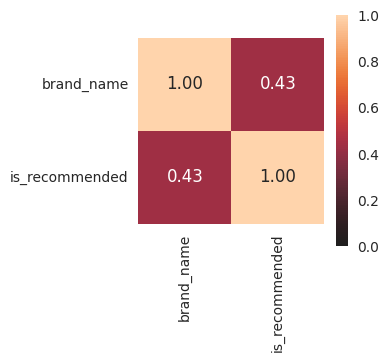

{'corr':                 brand_name  is_recommended
 brand_name        1.000000        0.431331
 is_recommended    0.431331        1.000000,
 'ax': <Axes: >}

In [192]:
associations(final_df[['brand_name','is_recommended']])

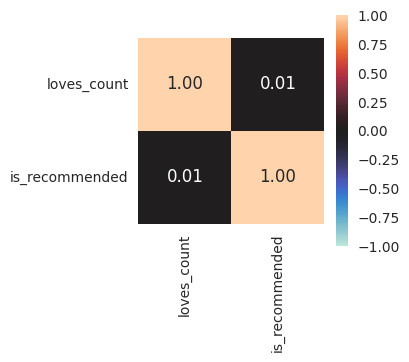

{'corr':                 loves_count  is_recommended
 loves_count        1.000000        0.008183
 is_recommended     0.008183        1.000000,
 'ax': <Axes: >}

In [193]:
associations(final_df[['loves_count','is_recommended']])

In [194]:
final_df.sort_values('price_usd', ascending=False)[['product_name','price_usd','is_recommended','rating']]

,product_name,price_usd,is_recommended,rating
1924,Shani Darden by Déesse PRO LED Light Mask,1900.0,0.750000,3.750000
1919,DRx SpectraLite BodyWare Pro,465.0,0.750000,4.250000
1789,Trinity Facial Toning Device + Wrinkle Reducer...,449.0,0.583333,3.416667
1246,Touch Home Permanent Hair Removal Device,449.0,0.592593,3.370370
1227,Trinity + Eye and Lip Enhancer Attachment Bundle,449.0,0.632184,3.436782
...,...,...,...,...
666,Clean Eye Mask,3.5,0.831099,4.171582
1592,Vitamin Eye Masks,3.5,0.742857,3.942857
1844,Mini Cleansing Wipes - Coconut Water,3.0,0.800000,4.300000
23,Cleansing & Exfoliating Wipes,3.0,0.845455,4.317857


In [195]:
final_df = final_df.set_index('product_id')
final_df

,rating,is_recommended,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,product_name,brand_name,price_usd,brand_id,child_count,...,loves_count,new,online_only,out_of_stock,reviews,sephora_exclusive,size,tertiary_category,variation_type,variation_value
product_id,,,,,,,,,,,,,,,,,,,,,
P7880,4.286325,0.832764,1.513675,0.470940,1.042735,Soy Hydrating Gentle Face Cleanser,fresh,39.0,4348.0,2.0,...,282865.0,0.0,0.0,0.0,8733.0,0.0,5 oz/ 150 mL,Face Wash & Cleansers,Size,5 oz/ 150 mL
P218700,4.358300,0.859312,3.348178,0.677126,2.671053,100 percent Pure Argan Oil,Josie Maran,49.0,5922.0,2.0,...,134089.0,0.0,0.0,0.0,7763.0,0.0,1.7 oz/ 50 mL,Face Oils,Size,1.7 oz/ 50 mL
P248407,4.342334,0.834325,4.047597,0.866819,3.180778,Ultra Repair Cream Intense Hydration,First Aid Beauty,38.0,5972.0,3.0,...,300432.0,0.0,0.0,0.0,7539.0,0.0,6 oz/ 170 g,Moisturizers,Size,6 oz/ 170 g
P269122,4.548879,0.940250,2.583975,0.597500,1.986475,Alpha Beta Extra Strength Daily Peel Pads,Dr. Dennis Gross Skincare,92.0,5668.0,2.0,...,234295.0,0.0,0.0,0.0,7412.0,1.0,30 Treatments + 5 Bonus,Facial Peels,Size,30 Treatments + 5 Bonus
P394639,4.486359,0.897692,1.167016,0.277894,0.889122,The True Cream Aqua Bomb,belif,38.0,7075.0,2.0,...,265050.0,0.0,0.0,0.0,7292.0,0.0,1.68 oz/ 50 mL,Moisturizers,Size,1.68 oz/ 50 mL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P480441,3.000000,0.000000,6.000000,0.000000,6.000000,Retinol + Bakuchiol Serum 2.5x,Dr. Lara Devgan Scientific Beauty,300.0,6318.0,0.0,...,581.0,0.0,1.0,0.0,1.0,0.0,1 oz/ 30 mL,Face Serums,Size,1 oz/ 30 mL
P469829,5.000000,1.000000,20.000000,3.000000,17.000000,Equilibrium Biomimetic Skin Active Serum,Hourglass,198.0,5879.0,1.0,...,482.0,0.0,0.0,0.0,1.0,0.0,1.7 oz/ 50 mL,Face Serums,Size,1.7 oz/ 50 mL
P505174,5.000000,1.000000,3.000000,0.000000,3.000000,Soft Clean Moisture Rich Foaming Cleanser,Estée Lauder,26.0,6089.0,0.0,...,435.0,1.0,0.0,0.0,1.0,0.0,4.5 oz / 125 mL,Face Wash & Cleansers,Size,4.5 oz / 125 mL


## 看成分

In [196]:
stat_of_ingredients = pd.DataFrame(columns = dict_id.keys())
stat_of_ingredients

,P427421,P417238,P450271,P269122,P427417,P394639,P411387,P411540,P423688,P421275,...,P480441,P481993,P483086,P470538,P504417,P481397,P406656,P501175,P504424,P469801


In [197]:
for id in stat_of_ingredients.columns:

  if isinstance(final_df.loc[id, 'ingredients'], str):

    ingredients = final_df.loc[id,'ingredients'].split(',')
    ingredients = [item.strip("[]'. ").lower() for item in ingredients]
    ingredients = pd.Series(ingredients)
    stat_of_ingredients[id] = ingredients

  else:

    stat_of_ingredients[id] = pd.Series([])
    print(f"Warning: Non-string value encountered for product ID: {id}")

stat_of_ingredients

,P427421,P417238,P450271,P269122,P427417,P394639,P411387,P411540,P423688,P421275,...,P480441,P481993,P483086,P470538,P504417,P481397,P406656,P501175,P504424,P469801
0,water/aqua/eau,cetyl ethylhexanoate,alcohol denat,step 1:,aqua (water),water,water/aqua/eau,water,microcrystalline cellulose,salicylic acid 0.5%,...,isopentyldiol,aqua (water),water / aqua / eau,beta-glucan (from ganoderma lucidum) mbg,salicylic acid 2%,water\\aqua\\eau,octinoxate 7.5%,water / aqua / eau,aqua (water),glycerin
1,dicaprylyl carbonate,caprylic/capric triglyceride,fragrance (parfum),water/aqua/eau,niacinamide,dipropylene glycol,cocamidopropyl hydroxysultaine,centella asiatica leaf water,magnesium oxide,aloe barbadensis (aloe vera) leaf extract,...,dimethyl isosorbide,glycerin,butylene glycol,zinc (as l-optizinc l-methionine bound complex),aqua (water),isononyl isononanoate,titanium dioxide 1.5%water,glycerin,gluconolactone,potassium cocoyl glycinate
2,glycerin,peg-20 glyceryl triisostearate,water (aqua/eau),alcohol denat. (sd alcohol 40-b),pentylene glycol,glycerin,sodium cocoyl glutamate,isononyl isononanoate,sodium cocoyl isethionate,retinyl acetate (vitamin a),...,polysorbate 80,limnanthes alba (meadowfoam) seed oil,hydrogenated poly(c6-14 olefin),vitamin d2 (from agaricus bisporus),pentylene glycol,glycerin,cetyl ethylhexanoate,dimethicone,sodium hydroxide,water/aqua
3,cetearyl alcohol,peg-10 isostearate,benzyl salicylate,glycolic acid,zinc pca,methl trimethicone,sorbeth-230 tetraoleate,cyclopentasiloxane,colloidal oatmeal,hydrocolloid polymer technology,...,ethoxydiglycol,hydrogenated coco-glycerides,octyldodecyl myristate,vitamin c (as ascorbic acid),vaccinium myrtillus fruit extract,c12-20 acid peg-8 ester,butylene glycol,methyl gluceth-20,lactic acid,butylene glycol
4,cetearyl olivate,polyethylene,hydroxycitronellal,potassium hydroxide,dimethyl isosorbide,alcohol denat,polysorbate 20,butylene glycol,disodium lauryl sulfosuccinate,NaN,...,caffeine,pentaerythrityl tetraisostearate,glycerin,vegetable capsule (hypromellose),xanthan gum,ascorbyl glucoside,octyldodecyl neopentanoate,butylene glycol,butylene glycol,polyglyceryl-10 myristate
5,sorbitan olivate,echinacea purpurea root extract,coumarin,hamamelis virginiana (witch hazel) water,tamarindus indica seed gum,dimethicone,sodium chloride,dimethicone,sodium lauroyl glutamate,NaN,...,camellia sinensis (green tea) polyphenols,octyldodecanol,polyglyceryl-3 methylglucose distearate,NaN,sodium hydroxide,dimethicone,peg-100 stearate,peg-15 glyceryl isostearate,citric acid,glyceryl stearate se
6,sclerocarya birrea seed oil,carica papaya (papaya) fruit extract,limonene,salicylic acid*,xanthan gum,cyclopentasiloxane,aloe barbadensis leaf (aloe vera) juice powder,phenyl trimethicone,oryza sativa (rice) bran extract,NaN,...,retinol,cetyl alcohol,cetyl ethylhexanoate,NaN,saccharum officinarum (sugar cane) extract,butyrospermum parkii (shea) butter,glyceryl stearate,panax ginseng root powder,glycerin,glycol distearate
7,bacillus/ folic acid ferment filtrate extract,moringa pterygosperma seed extract,farnesol,polysorbate 20,isoceteth-20,1,brassica oleracea acephala (kale) leaf extract,methyl methacrylate crosspolymer,oryza sativa (rice) starch,NaN,...,polysorbate 20,glyceryl stearate,limnanthes alba (meadowfoam) seed oil,NaN,glycerin,butylene glycol,glycerin,alcohol denat,salicylic acid,citric acid
8,nymphaea alba root extract,moringa oleifera seed oil,geraniol,lactic acid,ethoxydiglycol,2-hexanediol,spinacia oleracea (spinach) leaf extract,beeswax/cire d’abeille,hydrogenated coconut acid,NaN,...,bakuchiol,peg-100 stearate,hydrogenated vegetable oil,NaN,saccharide isomerate,cetyl alcohol,hydrogenated lecithin,polyglycerin-3,mentha piperita (peppermint) leaf extract,fragrance/parfum
9,sh-oligopeptide-1,zingiber officinale (ginger) root oil,benzyl alcohol,mandelic acid,phenoxyethanol,malakite extract,camellia sinensis (green tea) leaf extract,glycerin,allantoin,NaN,...,purified water,mel (honey),cetearyl alcoh

In [198]:
stat_of_ingredients_T = stat_of_ingredients.T
stat_of_ingredients_T

,0,1,2,3,4,5,6,7,8,9,...,49,50,51,52,53,54,55,56,57,58
P427421,water/aqua/eau,dicaprylyl carbonate,glycerin,cetearyl alcohol,cetearyl olivate,sorbitan olivate,sclerocarya birrea seed oil,bacillus/ folic acid ferment filtrate extract,nymphaea alba root extract,sh-oligopeptide-1,...,1,2-hexanediol,caprylyl glycol,chlorphenesin,phenoxyethanol,tocopherol,sodium benzoate,phenylpropanol,glyceryl caprylate,symphytum officinale callus culture extract
P417238,cetyl ethylhexanoate,caprylic/capric triglyceride,peg-20 glyceryl triisostearate,peg-10 isostearate,polyethylene,echinacea purpurea root extract,carica papaya (papaya) fruit extract,moringa pterygosperma seed extract,moringa oleifera seed oil,zingiber officinale (ginger) root oil,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P450271,alcohol denat,fragrance (parfum),water (aqua/eau),benzyl salicylate,hydroxycitronellal,coumarin,limonene,farnesol,geraniol,benzyl alcohol,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P269122,step 1:,water/aqua/eau,alcohol denat. (sd alcohol 40-b),glycolic acid,potassium hydroxide,hamamelis virginiana (witch hazel) water,salicylic acid*,polysorbate 20,lactic acid,mandelic acid,...,polysorbate 20,octoxynol-9,tetrasodium edta,phenoxyethanol,sodium benzoate,potassium sorbate,NaN,NaN,NaN,NaN
P427417,aqua (water),niacinamide,pentylene glycol,zinc pca,dimethyl isosorbide,tamarindus indica seed gum,xanthan gum,isoceteth-20,ethoxydiglycol,phenoxyethanol,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P481397,water\\aqua\\eau,isononyl isononanoate,glycerin,c12-20 acid peg-8 ester,ascorbyl glucoside,dimethicone,butyrospermum parkii (shea) butter,butylene glycol,cetyl alcohol,moringa oleifera seed extract,...,sodium hydroxide,t-butyl alcohol,ammonium acryloyldimethyltaurate/vp copolymer,fragrance (parfum),bht,disodium edta,sodium citrate,sodium benzoate,potassium sorbate,sodium dehydroacetate
P406656,octinoxate 7.5%,titanium dioxide 1.5%water,cetyl ethylhexanoate,butylene glycol,octyldodecyl neopentanoate,peg-100 stearate,glyceryl stearate,glycerin,hydrogenated lecithin,polyethylene,...,behenyl alcohol,methicone,hexylene glycol,xanthan gum,sodium hyaluronate,potassium hydroxide,potassium sulfate,glycine,potassium sorbate,aluminum hydroxide
P501175,water / aqua / eau,glycerin,dimethicone,methyl gluceth-20,butylene glycol,peg-15 glyceryl isostearate,panax ginseng root powder,alcohol denat,polyglycerin-3,glyceryl polymethacrylate,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
P504424,aqua (water),gluconolactone,sodium hydroxide,lactic acid,butylene glycol,citric acid,glycerin,salicylic acid,mentha piperita (peppermint) leaf extract,zingiber officinale root extract (zingiber off...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [199]:
import re

def standardize_ingredient(ingredient):

  if not isinstance(ingredient, str):
      return ingredient

  if re.search(r'\b(water|aqua|eau)\b', ingredient):
      return 'water'
  return ingredient


In [200]:
stat_of_ingredients_T[0] = stat_of_ingredients_T[0].apply(standardize_ingredient)
stat_of_ingredients_T[0].value_counts()

,count
0,
water,1365
glycerin,25
caprylic/capric triglyceride,19
squalane,15
avobenzone 3%,14
...,...
xiyuan jade,1
vinolevure: strengthens,1
rosa canina fruit oil,1


In [201]:
has_water = stat_of_ingredients_T[stat_of_ingredients_T[0]=='water'].index
not_water = stat_of_ingredients_T[stat_of_ingredients_T[0]!='water'].index

In [202]:
has_water_price = final_df.loc[stat_of_ingredients_T[stat_of_ingredients_T[0]=='water'].index, 'price_usd']
not_water_price = final_df.loc[stat_of_ingredients_T[stat_of_ingredients_T[0]!='water'].index, 'price_usd']

In [203]:
not_water_price = not_water_price.drop(not_water_price[not_water_price==1900].index)

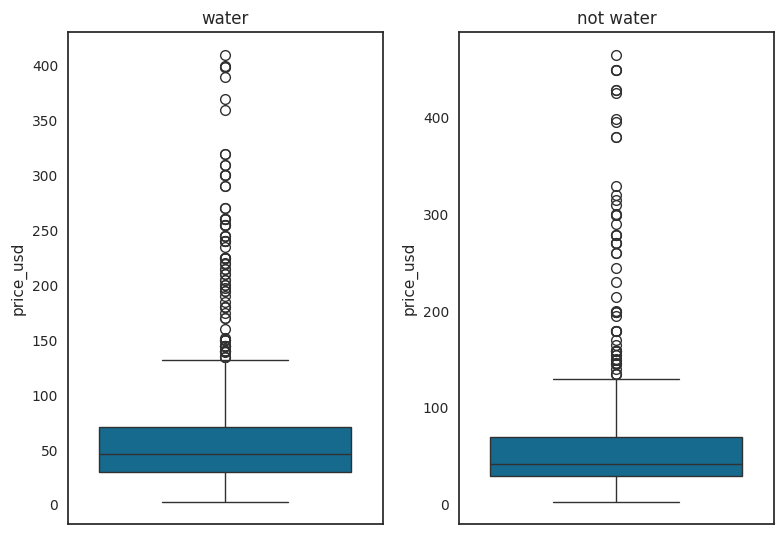

In [204]:
plt.subplot(1,2,1)
sns.boxplot(y=has_water_price)
plt.title('water')
plt.subplot(1,2,2)
sns.boxplot(y=not_water_price)
plt.title('not water')
plt.tight_layout()
plt.show()

# Model

In [205]:
get_overview(final_df)

df info : 


,variable,dtype,count,unique,missing
0,highlights,object,1998,1419,369
1,variation_value,object,1998,467,208
2,variation_type,object,1998,6,170
3,size,object,1998,457,155
4,ingredients,object,1998,1798,116
5,product_name,object,1998,1986,0
6,brand_name,object,1998,137,0
7,total_feedback_count,float64,1998,1862,0
8,tertiary_category,object,1998,30,0
9,total_neg_feedback_count,float64,1998,1715,0


In [209]:
kill_col = ['highlights','variation_value','variation_type','size','size','product_name']
final_df.drop(columns=kill_col,axis=1,inplace=True)

In [210]:
get_overview(final_df)

df info : 


,variable,dtype,count,unique,missing
0,ingredients,object,1998,1798,116
1,is_recommended,float64,1998,1375,0
2,sephora_exclusive,float64,1998,2,0
3,reviews,float64,1998,837,0
4,out_of_stock,float64,1998,2,0
5,online_only,float64,1998,2,0
6,new,float64,1998,2,0
7,loves_count,float64,1998,1930,0
8,limited_edition,float64,1998,2,0
9,rating,float64,1998,1591,0


In [211]:
train, test = train_test_split(final_df, test_size=0.2, random_state=42)

pre_set = setup(data=train, target='is_recommended', session_id=123, normalize=True, normalize_method='zscore')

,Description,Value
0,Session id,123
1,Target,is_recommended
2,Target type,Regression
3,Original data shape,"(1598, 18)"
4,Transformed data shape,"(1598, 18)"
5,Transformed train set shape,"(1118, 18)"
6,Transformed test set shape,"(480, 18)"
7,Numeric features,14
8,Categorical features,3
9,Rows with missing values,5.8%


In [212]:
X_train = get_config('X_train_transformed')
X_test = get_config('X_test_transformed')
y_train = get_config('y_train_transformed')
y_test = get_config('y_test_transformed')

In [213]:
X_train

,rating,total_feedback_count,total_neg_feedback_count,total_pos_feedback_count,brand_name,price_usd,brand_id,child_count,ingredients,limited_edition,loves_count,new,online_only,out_of_stock,reviews,sephora_exclusive,tertiary_category
product_id,,,,,,,,,,,,,,,,,
P422012,-0.865610,0.012062,-0.163839,0.071623,-0.070665,-0.315548,0.424854,-0.330961,-0.881120,-0.095001,-0.038652,-0.242306,-0.492161,-0.216371,-0.374406,-0.637408,0.053393
P407387,-0.154236,-0.363783,-0.221686,-0.394362,0.574073,-0.659977,0.939370,-0.330961,-0.006178,-0.095001,-0.265882,-0.242306,-0.492161,-0.216371,-0.301737,-0.637408,0.363571
P139000,0.240837,-0.461641,-0.307955,-0.491337,-2.219961,-0.493913,-2.644928,3.084558,0.395160,-0.095001,0.647682,-0.242306,-0.492161,-0.216371,2.237826,-0.637408,0.168658
P467750,0.905113,-0.519814,-0.426392,-0.526018,1.136621,0.065784,-0.841029,-0.330961,0.885676,-0.095001,-0.050031,-0.242306,-0.492161,-0.216371,-0.147477,-0.637408,0.053393
P474116,0.566775,-0.266777,-0.411938,-0.203918,1.306674,0.102687,0.511431,-0.330961,0.771836,-0.095001,-0.433871,-0.242306,2.031856,-0.216371,-0.514643,-0.637408,-1.800244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P482551,0.908240,-0.656516,-0.504387,-0.676028,0.087641,0.016580,0.335185,0.807545,1.007320,-0.095001,-0.214094,-0.242306,-0.492161,-0.216371,0.097300,-0.637408,0.053393
P500778,1.039598,-0.733585,-0.664041,-0.721036,0.528237,-0.413956,0.599245,-0.330961,0.954430,-0.095001,-0.446791,-0.242306,2.031856,-0.216371,-0.399903,1.568853,-1.686809
P392248,0.441224,-0.316812,0.189693,-0.474345,-0.712384,-0.438558,0.959778,-0.330961,0.336078,-0.095001,-0.129434,-0.242306,2.031856,-0.216371,-0.002140,-0.637408,0.168658


In [214]:
model = sm.OLS(y_train, sm.add_constant(X_train)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:         is_recommended   R-squared:                       0.932
Model:                            OLS   Adj. R-squared:                  0.931
Method:                 Least Squares   F-statistic:                     881.6
Date:                Fri, 27 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:07:15   Log-Likelihood:                 2140.7
No. Observations:                1118   AIC:                            -4245.
Df Residuals:                    1100   BIC:                            -4155.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [215]:
preserve_col = ['rating','brand_name','limited_edition','reviews','sephora_exclusive','tertiary_category']

In [216]:
X_train_filtered = X_train[preserve_col]
X_test_filtered = X_test[preserve_col]

In [217]:
model_filter = sm.OLS(y_train, sm.add_constant(X_train_filtered)).fit()
print(model_filter.summary())

                            OLS Regression Results                            
Dep. Variable:         is_recommended   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.903
Method:                 Least Squares   F-statistic:                     1743.
Date:                Fri, 27 Dec 2024   Prob (F-statistic):               0.00
Time:                        20:07:16   Log-Likelihood:                 1950.8
No. Observations:                1118   AIC:                            -3888.
Df Residuals:                    1111   BIC:                            -3853.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.8168      0.00

In [218]:
sse_ori = np.sum((model_filter.predict(sm.add_constant(X_train_filtered)) - y_test)**2)
ssr_ori = np.sum((model_filter.predict(sm.add_constant(X_train_filtered)) - np.mean(y_test))**2)

print(f"sse_ori: {sse_ori}")
print(f"ssr_ori: {ssr_ori}")

sse_ori: 0.0
ssr_ori: 18.79905774051515


In [219]:
sse = np.sum((model_filter.predict(sm.add_constant(X_test_filtered)) - y_test)**2)
ssr = np.sum((model_filter.predict(sm.add_constant(X_test_filtered)) - np.mean(y_test))**2)
ssto = np.sum((y_test - np.mean(y_test))**2)

In [220]:
print(f"ssr: {ssr}")
print(f"sse: {sse}")
print(f"ssto: {ssto}")

ssr: 8.057659039628335
sse: 0.846188568451713
ssto: 9.213890075683594


# Residual plot

In [221]:
y_hat = model_filter.predict(sm.add_constant(X_test_filtered))
residual = y_hat - y_test

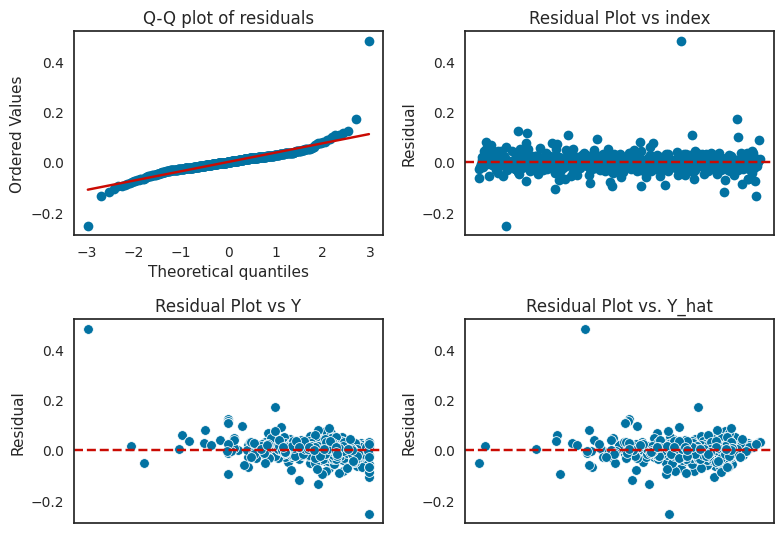

In [222]:
sns.set_style("white")
plt.subplot(2,2,1)
stats.probplot(residual, dist='norm', plot=plt)
plt.title('Q-Q plot of residuals')

plt.subplot(2,2,2)
plt.plot(residual,'o')
plt.axhline(y=0, color='r', linestyle='--')
plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel('Residual')
plt.title('Residual Plot vs index')

plt.subplot(2,2,3)
sns.scatterplot(x=y_test, y=residual)
plt.axhline(y=0, color='r', linestyle='--')
plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel('Residual')
plt.xlabel('Y')
plt.title('Residual Plot vs Y')

plt.subplot(2,2,4)
sns.scatterplot(x=y_hat, y=residual)
plt.axhline(y=0, color='r', linestyle='--')
plt.gca().axes.get_xaxis().set_visible(False)
plt.ylabel('Residual')
plt.xlabel('Y_hat')
plt.title('Residual Plot vs. Y_hat')

plt.tight_layout()
plt.show()

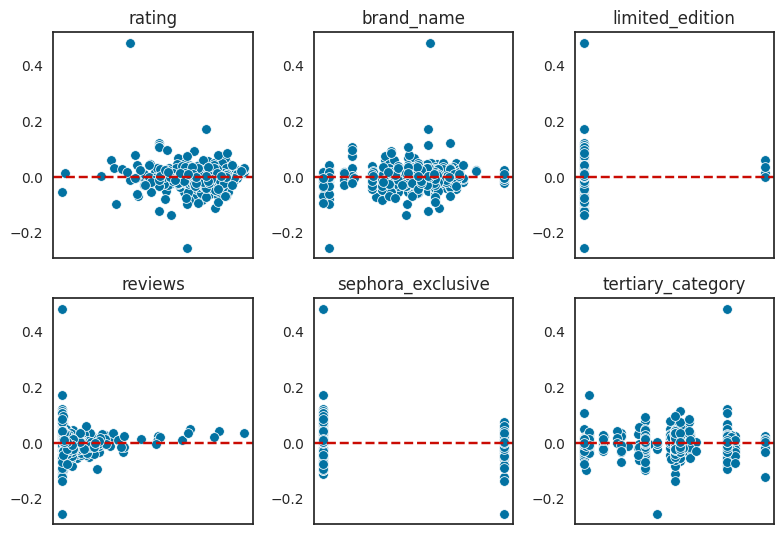

In [223]:
for idx, col in enumerate(X_test_filtered.columns):
  plt.subplot(2,3,idx+1)
  sns.scatterplot(x=X_test_filtered[col], y=residual)
  plt.axhline(y=0, color='r', linestyle='--')
  plt.gca().axes.get_xaxis().set_visible(False)
  plt.ylabel('')
  plt.xlabel(col)
  plt.title(f'{col}')

plt.tight_layout()
plt.show()